In [307]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json


In [101]:
#Sessions dataset

session_data = pd.read_parquet("Z:\dataframes\df.parquet.gzip")
session_data = session_data.drop_duplicates()
#session_data

#Dropping the rows which have readings of test subjects
session_data = session_data[~session_data['patient'].str.startswith('t')]
session_data = session_data[~session_data['patient'].str.startswith('T')]
session_data

,patient,databasePatientID,clinicProvidedIdentifier,forename,surname,dateOfBirth,weight,height,sex,email,notes,icds_a,icds_b,miscs,dateModified,dateCreated
0,75OYM,443D1C89-0C49-4683-8F8C-A6B8979F502D,75OYM,,,2022-06-15,1,1,F,,,,,Alzheimers,2022-06-15 15-17-42.983,2022-06-15 15-17-42.983
1,CO1,E48B0CE1-A5EF-4805-933E-504840A063EC,CO1,,,1900-01-01,180,70,male,,,,,,2022-04-19 13-08-29.507,2021-08-26 15-13-52.487
2,CON1,C2902752-88A5-4410-BD72-73706EE0A5B3,CON1,,,1961-02-14,264.6,178,Male,,Control patient. Not registered on Covid Repos...,,,,2022-04-19 13-09-30.990,1970-01-01 01-00-00.000
3,con10v,197CD3EE-C859-4711-8C2E-BD8785E4E62C,con10v,,,1997-07-05,1,1,Female,,,,,,2022-04-19 13-11-29.460,2021-05-28 17-32-23.647
4,CON2,A35FCA00-0336-4DB6-958F-6DF2E31851C6,CON2,,,2003-01-12,155,5.9,Male,,Not tested for COVID; not known to have had CO...,,,,2022-04-19 13-09-19.350,2021-02-21 18-17-39.973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,qc44-qcg49,5BC73D3A-16C7-4176-A067-6DA7BD1D3CED,qc44-qcg49,,,1959-07-20,1,1,female,,,,,,2022-04-19 13-09-15.710,2021-05-11 16-01-31.923
160,qc45v - qc - 52,3CC13185-BA6A-4ED2-8D8D-FDECA7F8A0AE,qc45v - qc - 52,,,1969-05-15,1,1,Female,,,,,,2022-04-19 13-12-56.820,2021-06-01 13-52-59.577
161,qc47 - qcg53,AD16C6FA-8A54-4E3A-8F10-41E459E33A49,qc47 - qcg53,,,1977-12-09,1,1,Female,,,,,,2022-04-19 13-07-59.147,2021-06-14 18-05-22.900
162,QC48V-QCG-58,AF5DC079-739E-4A37-90E6-539D08CB2CFC,QC48V-QCG-58,,,1950-08-22,5,33,Female,,,,,,2022-04-19 13-08-41.210,2021-09-30 14-03-16.797


In [102]:
#Function to calculate velocity (mean, max,), number of steps, swing length (average and standard) from joint data

def  gaitsession_etl():
    # Load basic patient metrics, session data and gait metrics generated by Stepsense API
    # Calculate detailed gait parameters

    # df_patients = pd.read_parquet('Z:\digital_health\COVID Study FAU-NOVID\df.parquet.gzip')
    df = pd.read_parquet('Z:\digital_health\COVID Study FAU-NOVID\dataframes\df_session.parquet.gzip')
    # df_gaitmetrics = pd.read_parquet('Z:\digital_health\COVID Study FAU-NOVID\gaitmetrics_etl.parquet.gzip')
    
    # select 'Laps Walking Application (Laps App)' sessions from df['testName']
    df_s = df[df['testName'].str.contains('Laps Walking Application')]
#    df_s = np.where(df['testName'].str.contains('Laps Walking Application'), 1, 0)

    patient_list = df_s['patient'].tolist()
    identifier_list = df_s['identifier'].tolist()
    # print(type(patient_list[0]))

    res = np.empty(shape=(len(patient_list), 6))
    for i in range(len(patient_list)):
        path = 'Z:\digital_health\COVID Study FAU-NOVID\\raw_data\COVID Study FAU\patients\%s\sessions\\%s\\files'%(patient_list[i], identifier_list[i])
        name = '%s_jointdata.json'%(identifier_list[i])
        filename = os.path.join(path, name)
        # print('name', name)
        if os.path.isfile(filename):   # Path(path).is_dir() and
            rois_df = pd.read_pickle("./rois.pkl")
            # print(rois_df)
            if name in rois_df['Name'].values:
                roi_start = rois_df[(rois_df == name).any(axis=1)]['roi_start'].iloc[0]
                roi_end = rois_df[(rois_df == name).any(axis=1)]['roi_end'].iloc[0]
            else: roi_start = 0; roi_end = 0

            if (roi_start <= roi_end-20): # fudge to miss if ROI is less than 1 sec (20n*0.05sec)
                res1 = CalcStepTime(path, name, roi_start, roi_end)
                #print('new output', res1)
            else: res1 = [3, np.nan, np.nan]

            res_tmp = calc_vel(path, name)  # only used to get points
            # print(res_tmp[0])
            # res[i,[0,1]] = res_tmp([0,1])
            # res[i,0] = res_tmp[0]
            # res[i,1] = res_tmp[1]
            ts_0 = res_tmp[2]
            td_0 = res_tmp[3]
            
            #to_vert_mask, from_vert_mask = masks(ts_0)  #  time axis
            #to_horiz_mask, from_horiz_mask = masks(td_0)  # displacment axis
            to_horiz_mask = grad_mask(td_0, ts_0)  # dist, sec
            # print(len(to_horiz_mask))
            to_horiz_mask = remove_noise(to_horiz_mask, spacing=30) # at ca 0.05 is 1.25 seconds
            # print(len(to_horiz_mask))
            to_horiz_t =  ts_0[to_horiz_mask] 
            to_horiz_v = td_0[to_horiz_mask]
            #to_vert_t, to_vert_v = apply_mask(to_vert_mask, ts_0, td_0)
            #from_vert_t, from_vert_v = apply_mask(from_vert_mask, ts_0, td_0)
            #to_horiz_t, to_horiz_v = apply_mask(to_horiz_mask, ts_0, td_0)
            #from_horiz_t, from_horiz_v = apply_mask(from_horiz_mask, ts_0, td_0)
            
            if len(to_horiz_t) > 2:
                vel_cut = np.gradient(to_horiz_v, to_horiz_t)
                res[i,0] = np.average(np.abs(vel_cut))
                res[i,1] = np.std(vel_cut)
                res[i,2] = np.average(np.sort(np.abs(vel_cut))[::-1][:10])  # average of 10 largest values
                res[i,3] = res1[0]
                res[i,4] = res1[1]
                res[i,5] = res1[2]
                #-np.average(np.partition(-np.abs(vel_cut), 10)) 

            else:
                res[i,[0,1]] = [np.nan, np.nan]

            # plt.figure()
            # plt.title("%s:%s"%(patient_list[i], identifier_list[i]))
            # plt.suptitle("%s mm/s"%(res[i,0]))  # res_tmp[0]
            # plt.xlabel("Time, [s]")
            # plt.ylabel("Movement, [mm]")
            # plt.plot(ts_0, td_0, color ="blue")
            # plt.plot(to_horiz_t, to_horiz_v, 'r>', label='Points used for vel calc')            
            # plt.legend()
            # plt.savefig("value_%s.png"%(identifier_list[i]))
            # plt.clf()

## add some demarkation to the figures to confirm the correct parts have been selected.
# https://stackoverflow.com/questions/47342447/find-locations-on-a-curve-where-the-slope-changes
            # plt.plot(x[1:len(x)], forward_vel, color ="yellow", label="vel")
        else:
            res[i,[0,1,2]] = [4, np.nan, np.nan]
    
    # format data into pd df
    df_gait_data = pd.DataFrame(res, columns=['vel_mean', 'vel_std', 'vel_max', 'l_steps', 'l_swing_av', 'l_swing_std'])
    df_gait_data['patient'] = patient_list
    df_gait_data['identifier'] = identifier_list
    df_gait_data = df_gait_data[['patient', 'identifier', 'vel_mean', 'vel_std', 'vel_max', 'l_steps', 'l_swing_av', 'l_swing_std']]
    # print(df_gait_data.to_string())
    # print(df_gait_data.dtypes)

    # save data
    df_gait_data.to_parquet('Z:\digital_health\COVID Study FAU-NOVID\dataframes\gait_data.parquet.gzip', compression='gzip')
    
    df_gait_data.to_csv('out.csv')

In [324]:
#Velocity dataset

vel_data = pd.read_parquet("Z:\dataframes\gait_data.parquet.gzip")
vel_data = vel_data.drop_duplicates()

#Dropping the rows which have readings of test subjects
vel_data = vel_data[~vel_data['patient'].str.startswith('t')]
vel_data = vel_data[~vel_data['patient'].str.startswith('T')]
vel_data

,patient,identifier,vel_mean,vel_std,vel_max,l_steps,l_swing_av,l_swing_std
0,CO1,2021-08-26 15-37-34.337,413.684573,94.270041,587.149361,5.0,0.552000,0.040694
1,CO1,2021-08-26 15-38-20.480,445.929179,117.786664,663.993226,6.0,0.568333,0.218892
2,CO1,2021-08-26 15-39-01.493,885.451303,204.056288,1163.489184,3.0,0.790000,0.312090
3,CO1,2021-08-26 15-39-19.207,980.803992,294.405675,1261.901622,1.0,2.900000,0.000000
4,CO1,2021-08-26 15-39-38.817,1318.880352,535.973867,1916.147020,1.0,0.900000,0.000000
...,...,...,...,...,...,...,...,...
968,QC48V-QCG-58,2021-09-30 19-09-54.753,896.674944,326.897691,1369.150934,3.0,0.893333,0.290440
969,QC48V-QCG-58,2021-09-30 19-10-13.107,740.116280,601.154311,1234.996412,2.0,0.620000,0.020000
970,QC49V-QCG-59,2021-10-29 14-53-11.770,4.000000,NaN,NaN,0.0,0.000000,0.000000
971,QC49V-QCG-59,2021-10-29 14-53-45.590,4.000000,NaN,NaN,0.0,0.000000,0.000000


In [311]:
#Test dataset

test_data = pd.read_parquet('Z:\dataframes\df_session.parquet.gzip')
test_data = test_data.drop_duplicates()

test_data = test_data[~test_data['patient'].str.startswith('t')]
test_data = test_data[~test_data['patient'].str.startswith('T')]
test_data

#test_data_filtered = test_data.iloc[:,[0,1,4,6]]
#test_data_filtered

,patient,identifier,databaseSessionID,databaseSubSessionID,testName,testDescription,testSpecificMetrics,hasJointData,hasGaitMetrics,hasVideo,dateModified,dateCreated
0,CO1,2021-08-26 15-20-35.183,93C9E2E4-6AF2-4077-B27A-471BC45FCECE,7F3D0C47-9D66-436F-93BC-361B1D284881,Gans Sensory Organization Performance (SOP) Test,"Balance analysis using Romberg, CTSIB and Fuku...","Romberg (Open Eyes), Score:",true,true,true,2021-08-26 15-20-35.183,2021-08-26 15-20-35.183
1,CO1,2021-08-26 15-21-13.817,F5542BF7-E51C-4581-9A06-AB50D9369FB7,F2A6F53D-4620-4F2F-B507-54C03356EACD,Gans Sensory Organization Performance (SOP) Test,"Balance analysis using Romberg, CTSIB and Fuku...","Romberg (Closed Eyes), Score:",true,true,true,2021-08-26 15-21-13.817,2021-08-26 15-21-13.817
2,CO1,2021-08-26 15-22-19.870,31857AB0-056B-4D79-A6D8-D731C2C3FB07,23146561-4C8B-4FF5-9B4F-4E160B480BBA,Gans Sensory Organization Performance (SOP) Test,"Balance analysis using Romberg, CTSIB and Fuku...","Tandem Romberg (Open Eyes), Score:",true,true,true,2021-08-26 15-22-19.870,2021-08-26 15-22-19.870
3,CO1,2021-08-26 15-23-41.717,1CC04B14-0154-4ADE-94AB-36B485F2A737,8500898A-16D4-4A6E-9B2B-E20CC93137F0,Gans Sensory Organization Performance (SOP) Test,"Balance analysis using Romberg, CTSIB and Fuku...","Tandem Romberg (Closed Eyes), Score:",true,true,true,2021-08-26 15-23-41.717,2021-08-26 15-23-41.717
4,CO1,2021-08-26 15-24-50.670,25FBEE87-B7D7-48A6-9345-BFB7E3F91E0F,1C0259E8-92E9-4A0B-B221-DB8D57C819B7,Gans Sensory Organization Performance (SOP) Test,"Balance analysis using Romberg, CTSIB and Fuku...","CTSIB (Open Eyes), Score:",true,true,true,2021-08-26 15-24-50.670,2021-08-26 15-24-50.670
...,...,...,...,...,...,...,...,...,...,...,...,...
3250,QC49V-QCG-59,2021-10-29 14-55-02.980,3AC8618D-5268-4738-AACF-01136E480594,C6B1BF5A-88DF-45E9-96B7-68EF2EFA6EA4,Stroop Balance Assessment,"Engage, assess and score patient balance while...",,true,true,true,2021-10-29 14-55-02.980,2021-10-29 14-55-02.980
3251,QC49V-QCG-59,2021-10-29 14-55-42.470,93FAC5BA-8279-41D4-9493-F6D46D480A4B,AC5FFE73-E6F0-4D89-AE28-91A7947313B6,Stroop Balance Assessment,"Engage, assess and score patient balance while...","Romberg (Closed Eyes), Score:",true,true,true,2021-10-29 14-55-42.470,2021-10-29 14-55-42.470
3252,QC49V-QCG-59,2021-10-29 14-56-41.657,4CA3F17E-20DB-4DAE-830A-D4FE44C9B650,BD5FAE59-4B80-481F-81A2-8DCA6CBA3D9E,Stroop Balance Assessment,"Engage, assess and score patient balance while...",,true,true,true,2021-10-29 14-56-41.657,2021-10-29 14-56-41.657
3253,QC49V-QCG-59,2021-10-29 14-56-59.963,97B923C4-5DE7-4A40-9F37-D47BC500DB58,EC768EEB-A91D-4A10-8DF2-18AF2B621440,Stroop Balance Assessment,"Engage, assess and score patient balance while...","Tandem Romberg (Open Eyes), Score:",true,true,true,2021-10-29 14-56-59.963,2021-10-29 14-56-59.963


 *General calculations (Age, Male/Female, BMI)*

1. Calculating age for case and control

In [308]:
#Calculating age

#Function to calculate age
def calculate_age(dob):
    dob_datetime = datetime.strptime(dob, "%Y-%m-%d")
    current_date = datetime.now()
    age = current_date.year - dob_datetime.year - ((current_date.month, current_date.day) < (dob_datetime.month, dob_datetime.day))
    return age

session_data['age'] = session_data['dateOfBirth'].apply(calculate_age)
#session_data

#Calculating the mean age for case subjects

session_data_case_age = session_data[session_data['patient'].str.startswith('PP')]
session_data_case_age = session_data_case_age[(session_data_case_age['age'] <= 100) & (session_data_case_age['age'] >= 10)]
session_data_case_age['mean_age'] = session_data_case_age['age'].mean()
session_data_case_age_head = session_data_case_age.iloc[:,[0,-1]].head()
print(session_data_case_age_head)

#Calculating the mean age for control subjects

session_data_ctrl_age = session_data[~session_data['patient'].str.startswith('PP')]
session_data_ctrl_age = session_data_ctrl_age[(session_data_ctrl_age['age'] <= 100) & (session_data_ctrl_age['age'] >= 10)]
session_data_ctrl_age['mean_age'] = session_data_ctrl_age['age'].mean()
session_data_ctrl_age_head = session_data_ctrl_age.iloc[:,[0,-1]].head()
print(session_data_ctrl_age_head)

qq = session_data.copy()
qq = qq[(qq['age'] <= 100) & (qq['age'] >= 10)]
qq.iloc[:,-1]

   patient   mean_age
39  PP132V  49.727273
74   PP177  49.727273
76   PP179  49.727273
79   PP182  49.727273
81  PP186V  49.727273
  patient   mean_age
2    CON1  45.752294
3  con10v  45.752294
4    CON2  45.752294
5    CON3  45.752294
6    CON4  45.752294


2      63
3      27
4      21
5      59
6      24
       ..
159    65
160    55
161    46
162    73
163    26
Name: age, Length: 131, dtype: int64

2. Calculating the height for case and control

In [329]:
#Calculating the height for case subjects

#Function to calculate mean height
session_data_case_height = session_data[session_data['patient'].str.startswith('PP')]
session_data_case_height['height'] = pd.to_numeric(session_data_case_height['height'], errors='coerce')

def convert_and_calculate_mean(heights):

    # Remove one-digit values
    valid_heights = [h for h in heights if h > 9]
    
    # Convert heights to meters
    heights_in_meters = []
    for height in valid_heights:
        if height < 100:  # Assume it's in inches
            meters = height * 0.0254
        else:  # Assume it's in centimeters
            meters = height / 100
        heights_in_meters.append(meters)
    
    # Calculate the mean height in meters
    mean_height = np.mean(heights_in_meters)
    
    return mean_height

mean_height = convert_and_calculate_mean(session_data_case_height['height'].tolist())
session_data_case_height['mean height'] = mean_height
session_data_case_height_head = session_data_case_height.iloc[:,[0,-1]].head()
print(session_data_case_height_head)


#Calculating the height for control subjects
session_data_ctrl_height = session_data[~session_data['patient'].str.startswith('PP')]
session_data_ctrl_height['height'] = pd.to_numeric(session_data_ctrl_height['height'], errors='coerce')
session_data_ctrl_height.iloc[:,7]

#Function
def convert_and_calculate_mean_ctrl(heights):
 
    # Remove invalid heights (one-digit floats less than 4)
    valid_heights = []
    for h in heights:
        if isinstance(h, float) and h < 4:
            continue
        valid_heights.append(h)

    # Convert heights to meters
    heights_in_meters = []
    for height in valid_heights:
        if isinstance(height, int):
            if height < 100:  # Assume it's in inches
                meters = height * 0.0254
            else:  # Assume it's in centimeters
                meters = height / 100
        elif isinstance(height, float):  # Assume it's in feet
            meters = height * 0.3048
        heights_in_meters.append(meters)
    
    # Calculate the mean height in meters

    mean_height = np.mean(heights_in_meters)
    
    return mean_height

mean_height = convert_and_calculate_mean(session_data_ctrl_height['height'].tolist())
session_data_ctrl_height['mean height'] = mean_height
session_data_ctrl_height_head = session_data_ctrl_height.iloc[:,[0,-1]].head()
print(session_data_ctrl_height_head)

# For control subjects
session_data_ctrl_height = session_data[~session_data['patient'].str.startswith('PP')]
session_data_ctrl_height['height'] = pd.to_numeric(session_data_ctrl_height['height'], errors='coerce')

# Convert the heights
heights_in_meters_ctrl = convert_heights_ctrl(session_data_ctrl_height['height'].tolist())

# Calculate the mean height outside the function
mean_height_ctrl = np.mean(heights_in_meters_ctrl)

# Assign the mean height to all rows
session_data_ctrl_height['mean height'] = mean_height_ctrl
print(session_data_ctrl_height[['patient', 'mean height']].head())

   patient  mean height
39  PP132V     1.532433
74   PP177     1.532433
76   PP179     1.532433
79   PP182     1.532433
81  PP186V     1.532433
  patient  mean height
0   75OYM      1.62852
1     CO1      1.62852
2    CON1      1.62852
3  con10v      1.62852
4    CON2      1.62852


C:\Users\harim\AppData\Local\Temp\ipykernel_21516\3842968295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_height['height'] = pd.to_numeric(session_data_case_height['height'], errors='coerce')
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\3842968295.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_height['mean height'] = mean_height
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\3842968295.py:34: SettingWithCopyWarning: 
A value is trying to be set on a c

In [330]:
import pandas as pd
import numpy as np

# Function to convert heights for case subjects
def convert_heights_case(heights):
    # Remove one-digit values
    valid_heights = [h for h in heights if h > 9]
    
    # Convert heights to meters
    heights_in_meters = []
    for height in valid_heights:
        if height < 100:  # Assume it's in inches
            meters = height * 0.0254
        else:  # Assume it's in centimeters
            meters = height / 100
        heights_in_meters.append(meters)
    
    return heights_in_meters

# For case subjects
session_data_case_height = session_data[session_data['patient'].str.startswith('PP')]
session_data_case_height['height'] = pd.to_numeric(session_data_case_height['height'], errors='coerce')

# Convert the heights
heights_in_meters_case = convert_heights_case(session_data_case_height['height'].tolist())

# Calculate the mean height outside the function
mean_height_case = np.mean(heights_in_meters_case)

# Assign the mean height to all rows
session_data_case_height['mean height'] = mean_height_case
print(session_data_case_height[['patient', 'mean height']].head())

# Function to convert heights for control subjects
def convert_heights_ctrl(heights):
    # Remove invalid heights (one-digit floats less than 4)
    valid_heights = []
    for h in heights:
        if isinstance(h, float) and h < 4:
            continue
        valid_heights.append(h)

    # Convert heights to meters
    heights_in_meters = []
    for height in valid_heights:
        if isinstance(height, int):
            if height < 100:  # Assume it's in inches
                meters = height * 0.0254
            else:  # Assume it's in centimeters
                meters = height / 100
        elif isinstance(height, float):  # Assume it's in feet
            meters = height * 0.3048
        heights_in_meters.append(meters)
    
    return heights_in_meters

# For control subjects
session_data_ctrl_height = session_data[~session_data['patient'].str.startswith('PP')]
session_data_ctrl_height['height'] = pd.to_numeric(session_data_ctrl_height['height'], errors='coerce')

# Convert the heights
heights_in_meters_ctrl = convert_heights_ctrl(session_data_ctrl_height['height'].tolist())

# Calculate the mean height outside the function
mean_height_ctrl = np.mean(heights_in_meters_ctrl)

# Assign the mean height to all rows
session_data_ctrl_height['mean height'] = mean_height_ctrl
print(session_data_ctrl_height[['patient', 'mean height']].head())

   patient  mean height
39  PP132V     1.532433
74   PP177     1.532433
76   PP179     1.532433
79   PP182     1.532433
81  PP186V     1.532433
  patient  mean height
0   75OYM     22.42312
1     CO1     22.42312
2    CON1     22.42312
3  con10v     22.42312
4    CON2     22.42312


C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1418211536.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_height['height'] = pd.to_numeric(session_data_case_height['height'], errors='coerce')
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1418211536.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_height['mean height'] = mean_height_case
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1418211536.py:59: SettingWithCopyWarning: 
A value is trying to be set 

3. Calculating the number of male and female subjects

In [106]:
#Calculating for case subjects

session_data_case_gender = session_data[session_data['patient'].str.startswith('PP')]
subjects_case = session_data_case_gender.iloc[:,8] #Selecting sex column in the dataframe

# Normalize all entries to lowercase
normalized_subjects_case = [subject.lower() for subject in subjects_case]

# Count the number of males and females
num_males_case = normalized_subjects_case.count("male")
num_females_case = normalized_subjects_case.count("female")

# Print the results
print(f"Number of male case subjects: {num_males_case}")
print(f"Number of female case subjects: {num_females_case}")


#Calculating for control subjects

session_data_ctrl_gender = session_data[~session_data['patient'].str.startswith('PP')]
subjects_ctrl = session_data_ctrl_gender.iloc[:,8] #Selecting sex column in the dataframe

# Normalize all entries to lowercase
normalized_subjects_ctrl = [subject.lower() for subject in subjects_ctrl]

# Count the number of males and females
num_males_ctrl = normalized_subjects_ctrl.count("male")
num_females_ctrl = normalized_subjects_ctrl.count("female")

# Print the results
print(f"Number of male control subjects: {num_males_ctrl}")
print(f"Number of female control subjects: {num_females_ctrl}")


Number of male case subjects: 9
Number of female case subjects: 14
Number of male control subjects: 50
Number of female control subjects: 79


 4. Calculating the BMI 

In [123]:
#Calculating the BMI for case patients

session_data_case_BMI = session_data[session_data['patient'].str.startswith('PP')]
session_data_case_BMI['height'] = pd.to_numeric(session_data_case_BMI['height'], errors='coerce')
session_data_case_BMI['weight'] = pd.to_numeric(session_data_case_BMI['weight'], errors='coerce')
#session_data_case_BMI.iloc[:,[6,7]]

def convert_to_meters(height):

    if height > 9:  # Ensure the height is valid
        if height < 100:  # Assume height is in inches
            return height * 0.0254
        else:  # Assume height is in centimeters
            return height / 100
    return None  # Return None for invalid heights

def convert_to_kg(weight):

    if weight > 30:  # Ensure the weight is valid
        if weight > 90:  # Assume weight is in pounds
            return weight * 0.453592
        else:  # Assume weight is already in kilograms
            return weight
    return None  # Return None for invalid weights

def calculate_bmi(df):

    # Convert height to meters
    df['height_m'] = df['height'].apply(convert_to_meters)

    # Convert weight to kilograms
    df['weight_kg'] = df['weight'].apply(convert_to_kg)

    # Calculate BMI (only if both height and weight are valid)
    df['BMI'] = df.apply(lambda x: x['weight_kg'] / (x['height_m'] ** 2) if pd.notnull(x['height_m']) and pd.notnull(x['weight_kg']) else None, axis=1)

    return df

# Calculate BMI and store it in the DataFrame
session_data_case_BMI = calculate_bmi(session_data_case_BMI)
session_data_case_BMI_iloc =  session_data_case_BMI.iloc[:,[-1]]
session_data_case_BMI_clean = session_data_case_BMI_iloc.dropna()
session_data_case_BMI_mean = session_data_case_BMI_clean.mean()

print('The mean BMI of case subjects is: ', session_data_case_BMI_mean)



#Calculating the BMI for control patients

session_data_ctrl_BMI = session_data[~session_data['patient'].str.startswith('PP')]
session_data_ctrl_BMI['height'] = pd.to_numeric(session_data_ctrl_BMI['height'], errors='coerce')
session_data_ctrl_BMI['weight'] = pd.to_numeric(session_data_ctrl_BMI['weight'], errors='coerce')
#session_data_case_BMI.iloc[:,[6,7]]

def convert_to_meters(height):
    """Convert a single height value to meters."""
    if isinstance(height, float) and height < 4:  # Ignore invalid floats less than 4 feet
        return None
    elif isinstance(height, float) and height >= 4:  # Assume height is in feet
        if height <=8:
            return height * 0.3048
        if height < 100:  # Assume height is in inches
            return height * 0.0254
        else:
             return height / 100
    elif isinstance(height, int):
        if height < 100:  # Assume height is in inches
            return height * 0.0254
        else:  # Assume height is in centimeters
            return height / 100
    return None  # Return None for invalid heights

def convert_to_kg(weight):
    """Convert weight to kilograms."""
    weight = float(weight)
    if weight > 30:  # Ensure the weight is valid
        if weight > 90:  # Assume weight is in pounds
            return weight * 0.453592
        else:  # Assume weight is already in kilograms
            return weight
    return None  # Return None for invalid weights

def calculate_bmi(df):
    """Calculate BMI in kg/m²."""
    # Convert height to meters
    df['height_m'] = df['height'].apply(convert_to_meters)

    # Convert weight to kilograms
    df['weight_kg'] = df['weight'].apply(convert_to_kg)

    # Calculate BMI (only if both height and weight are valid)
    df['BMI'] = df.apply(lambda x: x['weight_kg'] / (x['height_m'] ** 2) if pd.notnull(x['height_m']) and pd.notnull(x['weight_kg']) else None, axis=1)

    return df

# Apply the conversion functions to each element in the height and weight columns
session_data_ctrl_BMI['height_m'] = session_data_ctrl_BMI['height'].apply(convert_to_meters)
session_data_ctrl_BMI['weight_kg'] = session_data_ctrl_BMI['weight'].apply(convert_to_kg)

session_data_ctrl_BMI = calculate_bmi(session_data_ctrl_BMI)
session_data_ctrl_BMI_iloc =  session_data_ctrl_BMI.iloc[:,[-1]]
session_data_ctrl_BMI_clean = session_data_ctrl_BMI_iloc.dropna()
session_data_ctrl_BMI_mean = session_data_ctrl_BMI_clean.mean()

print('The mean BMI of control subjects is: ', session_data_ctrl_BMI_mean)


The mean BMI of case subjects is:  BMI    26.385013
dtype: float64
The mean BMI of control subjects is:  BMI    25.731559
dtype: float64


C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1631436683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_BMI['height'] = pd.to_numeric(session_data_case_BMI['height'], errors='coerce')
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1631436683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_data_case_BMI['weight'] = pd.to_numeric(session_data_case_BMI['weight'], errors='coerce')
C:\Users\harim\AppData\Local\Temp\ipykernel_21516\1631436683.py:29: SettingWithCopyWarning

5. Performing t-test to calculate the p value of age, height and BMI

In [328]:
#Age 

group1_age = session_data_case_age['age'].dropna().astype(float) 
group2_age = session_data_ctrl_age['age'].dropna().astype(float) 

t_stat, p_value = ttest_ind(group1_age, group2_age)
print(f"P-value for age: {p_value}")

#Height

group1_height = pd.Series(heights_in_meters_case).dropna().astype(float)
group2_height = pd.Series(heights_in_meters_ctrl).dropna().astype(float)

t_stat, p_value = ttest_ind(group1_height, group2_height)
print(f"P-value for height: {p_value}")

#BMI

group1_BMI = session_data_case_BMI['BMI'].dropna().astype(float)
group2_BMI = session_data_ctrl_BMI['BMI'].dropna().astype(float)

t_stat, p_value = ttest_ind(group1_BMI, group2_BMI)
print(f"P-value for BMI: {p_value}")

P-value for age: 0.3458391018136763
P-value for height: 0.005920406452410198
P-value for BMI: 0.8357049079632831


$$ Building.a.model $$

1. Using velocity


In [211]:
#Showing the vel_mean, vel_max and average swing lenght for case and control

#CASE SUBJECTS
vel_data_case = vel_data[vel_data['patient'].str.startswith('PP')]

#Mean velocity
vel_data_case_vel_mean = vel_data_case.iloc[:,2]
vel_data_case_vel_mean = vel_data_case_vel_mean [vel_data_case_vel_mean >= 500]
print('The mean of average velocity in case subjects is: ' ,vel_data_case_vel_mean.mean())

#Max velocity
vel_data_case_vel_max = vel_data_case.iloc[:,4]
vel_data_case_vel_max = vel_data_case_vel_max[vel_data_case_vel_max >= 500]
print('The mean of maximum velocity in case subjects is: ' ,vel_data_case_vel_max.mean())





#CONTROL SUBJECTS
vel_data_ctrl = vel_data[~vel_data['patient'].str.startswith('PP')]

#Mean velocity
vel_data_ctrl_vel_mean = vel_data_ctrl.iloc[:,2]
vel_data_ctrl_vel_mean = vel_data_ctrl_vel_mean [vel_data_ctrl_vel_mean >= 500]
print('The mean of average velocity in control subjects is: ' ,vel_data_ctrl_vel_mean.mean())

#Max velocity
vel_data_ctrl_vel_max = vel_data_ctrl.iloc[:,4]
vel_data_ctrl_vel_max = vel_data_ctrl_vel_max[vel_data_ctrl_vel_max >= 500]
print('The mean of maximum velocity in control subjects is: ' ,vel_data_ctrl_vel_max.mean())



The mean of average velocity in case subjects is:  962.5858512783839
The mean of maximum velocity in case subjects is:  1312.9243656442616
The mean of average velocity in control subjects is:  947.0956143385935
The mean of maximum velocity in control subjects is:  1251.314483250638


In [209]:
dq = vel_data_case.iloc[:,2:]
dq.mean()

vel_mean        784.623403
vel_std         332.425484
vel_max        1266.423302
l_steps           3.540323
l_swing_av        0.875268
l_swing_std       0.266310
dtype: float64

In [212]:
#Calculating step length


# Base directory containing patient folders
base_directory = r"Z:\raw_data\COVID Study FAU\patients"

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + 
                   (point1[1] - point2[1])**2 + 
                   (point1[2] - point2[2])**2)

# Function to process a single joint data file and calculate step lengths
def process_joint_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the frames from the data
    frames = data["Steps"][0]["Frames"]

    step_lengths = []

    for frame in frames:
        # Extract 3D coordinates for Right Foot and Left Foot
        right_foot_pos = frame["Joint_Positions"][:3]  # Right Foot is the first 3 values
        left_foot_pos = frame["Joint_Positions"][3:6]  # Left Foot is the next 3 values
        
        # Convert to float
        right_foot_pos = list(map(float, right_foot_pos))
        left_foot_pos = list(map(float, left_foot_pos))
        
        # Calculate the step length (distance between left and right foot)
        step_length = euclidean_distance(right_foot_pos, left_foot_pos)
        
        step_lengths.append(step_length)

    average_step_length = np.mean(step_lengths)
    
    return average_step_length

# Function to filter patient sessions and process joint data files
def process_filtered_patients():

    df_sessions = pd.read_parquet(r'Z:\dataframes\df_session.parquet.gzip')

    df_filtered = df_sessions[df_sessions['testName'].str.contains('Laps Walking Application')]

    patient_list = df_filtered['patient'].tolist()
    identifier_list = df_filtered['identifier'].tolist()

    patient_results = []

    # Process each patient's session
    for i in range(len(patient_list)):
        patient_id = patient_list[i]
        session_id = identifier_list[i]

        # Construct the path to the joint data file
        file_path = os.path.join(base_directory, patient_id, 'sessions', session_id, 'files', f'{session_id}_jointdata.json')

        if os.path.isfile(file_path):
            # Process the joint data file and calculate the average step length
            average_step_length = process_joint_data(file_path)

            patient_results.append({
                'patient': patient_id,
                'identifier': session_id,
                'Average_Step_Length': average_step_length
            })
            print(f"Processed {file_path} for patient {patient_id}, session {session_id}: Average Step Length = {average_step_length:.2f} units")
        else:
            print(f"File not found: {file_path}")

    return patient_results

# Run the process for all filtered patients
filtered_patient_results = process_filtered_patients()

df_step_length = pd.DataFrame(filtered_patient_results)

output_file = r"Z:\raw_data\COVID Study FAU\patients\filtered_step_lengths.parquet.gzip"
df_step_length.to_parquet(output_file, compression='gzip')

print(f"Results saved to {output_file}")

Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-37-34.337\files\2021-08-26 15-37-34.337_jointdata.json for patient CO1, session 2021-08-26 15-37-34.337: Average Step Length = 179.87 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-38-20.480\files\2021-08-26 15-38-20.480_jointdata.json for patient CO1, session 2021-08-26 15-38-20.480: Average Step Length = 255.17 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-01.493\files\2021-08-26 15-39-01.493_jointdata.json for patient CO1, session 2021-08-26 15-39-01.493: Average Step Length = 189.62 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-19.207\files\2021-08-26 15-39-19.207_jointdata.json for patient CO1, session 2021-08-26 15-39-19.207: Average Step Length = 260.00 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-38.817\files\2021-08-26 15-39-38.817_jointdata.json for patient CO1

In [227]:
df_step_length

,patient,identifier,Average_Step_Length
0,CO1,2021-08-26 15-37-34.337,179.873115
1,CO1,2021-08-26 15-38-20.480,255.167705
2,CO1,2021-08-26 15-39-01.493,189.618769
3,CO1,2021-08-26 15-39-19.207,260.001445
4,CO1,2021-08-26 15-39-38.817,186.891469
...,...,...,...
1063,tt,2022-04-21 18-30-36.103,275.908280
1064,tt,2022-04-21 18-31-17.503,298.374641
1065,tt,2022-04-21 18-32-10.890,280.472972
1066,tt,2022-04-21 18-32-33.747,271.301508


In [215]:
#Calculating step width

# Base directory containing patient folders
base_directory = r"Z:\raw_data\COVID Study FAU\patients"

# Function to calculate the lateral (x-axis) distance between two points
def lateral_distance(point1, point2):
    # Only consider the x-coordinate (lateral distance)
    return abs(point1[0] - point2[0])

# Function to process a single joint data file and calculate step widths
def process_joint_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the frames from the data
    frames = data["Steps"][0]["Frames"]

    step_widths = []

    for frame in frames:
        
        right_foot_pos = frame["Joint_Positions"][:3]  # Right Foot is the first 3 values
        left_foot_pos = frame["Joint_Positions"][3:6]  # Left Foot is the next 3 values
        
        
        right_foot_pos = list(map(float, right_foot_pos))
        left_foot_pos = list(map(float, left_foot_pos))
        
        step_width = lateral_distance(right_foot_pos, left_foot_pos)

        step_widths.append(step_width)

    average_step_width = np.mean(step_widths)
    
    return average_step_width

# Function to filter patient sessions and process joint data files
def process_filtered_patients():

    df_sessions = pd.read_parquet(r'Z:\dataframes\df_session.parquet.gzip')

    df_filtered = df_sessions[df_sessions['testName'].str.contains('Laps Walking Application')]

    patient_list = df_filtered['patient'].tolist()
    identifier_list = df_filtered['identifier'].tolist()

    patient_results = []

    # Process each patient's session
    for i in range(len(patient_list)):
        patient_id = patient_list[i]
        session_id = identifier_list[i]

        # Construct the path to the joint data file
        file_path = os.path.join(base_directory, patient_id, 'sessions', session_id, 'files', f'{session_id}_jointdata.json')

        if os.path.isfile(file_path):
        
            average_step_width = process_joint_data(file_path)

            # Append the result with patient ID and session ID
            patient_results.append({
                'patient': patient_id,
                'identifier': session_id,
                'Average_Step_Width': average_step_width
            })
            print(f"Processed {file_path} for patient {patient_id}, session {session_id}: Average Step Width = {average_step_width:.2f} units")
        else:
            print(f"File not found: {file_path}")

    return patient_results

# Run the process for all filtered patients
filtered_patient_results = process_filtered_patients()

# Convert the results to a pandas DataFrame
df_step_width = pd.DataFrame(filtered_patient_results)

# Save the DataFrame to a Parquet file
output_file = r"Z:\raw_data\COVID Study FAU\patients\filtered_step_widths.parquet.gzip"
df_step_width.to_parquet(output_file, compression='gzip')

print(f"Results saved to output_file")

Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-37-34.337\files\2021-08-26 15-37-34.337_jointdata.json for patient CO1, session 2021-08-26 15-37-34.337: Average Step Width = 179.36 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-38-20.480\files\2021-08-26 15-38-20.480_jointdata.json for patient CO1, session 2021-08-26 15-38-20.480: Average Step Width = 253.87 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-01.493\files\2021-08-26 15-39-01.493_jointdata.json for patient CO1, session 2021-08-26 15-39-01.493: Average Step Width = 187.33 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-19.207\files\2021-08-26 15-39-19.207_jointdata.json for patient CO1, session 2021-08-26 15-39-19.207: Average Step Width = 258.56 units
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-38.817\files\2021-08-26 15-39-38.817_jointdata.json for patient CO1, se

In [225]:
df_step_width

,patient,identifier,Average_Step_Width
0,CO1,2021-08-26 15-37-34.337,179.361112
1,CO1,2021-08-26 15-38-20.480,253.867634
2,CO1,2021-08-26 15-39-01.493,187.333913
3,CO1,2021-08-26 15-39-19.207,258.563874
4,CO1,2021-08-26 15-39-38.817,186.383566
...,...,...,...
1063,tt,2022-04-21 18-30-36.103,254.432160
1064,tt,2022-04-21 18-31-17.503,262.823147
1065,tt,2022-04-21 18-32-10.890,246.537084
1066,tt,2022-04-21 18-32-33.747,270.605749


In [323]:
# Base directory containing patient folders
base_directory = r"Z:\raw_data\COVID Study FAU\patients"

# Function to calculate single support duration between two foot contact events
def calculate_single_support_duration(left_foot_down_time, right_foot_down_time):
    # Single support phase is the time period where only one foot is in contact with the ground
    single_support_durations = []
    
    # Calculate the single support duration for each step
    for i in range(1, len(left_foot_down_time)):
        single_support_duration = right_foot_down_time[i] - left_foot_down_time[i - 1]
        single_support_durations.append(single_support_duration)
    
    return single_support_durations

# Function to process a single joint data file and calculate single support durations
def process_joint_data_for_support_duration(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the frames and timing data from the file
    frames = data["Steps"][0]["Frames"]
    left_foot_down_time = []
    right_foot_down_time = []

    for frame in frames:
        # Identify when each foot is in contact with the ground
        right_foot_contact = frame["Joint_Positions"][:3]  # Right Foot is the first 3 values
        left_foot_contact = frame["Joint_Positions"][3:6]  # Left Foot is the next 3 values
        
        right_foot_contact = list(map(float, right_foot_contact))
        left_foot_contact = list(map(float, left_foot_contact))
        
        # Assuming the first value represents the timestamp for the foot contact event
        # Add condition to check foot contact and add corresponding times
        if right_foot_contact[2] == 0:  # Assuming '0' represents foot contact with the ground
            right_foot_down_time.append(frame['Time'])

        if left_foot_contact[2] == 0:  # Assuming '0' represents foot contact with the ground
            left_foot_down_time.append(frame['Time'])

    # Calculate the single support duration
    single_support_durations = calculate_single_support_duration(left_foot_down_time, right_foot_down_time)

    average_single_support_duration = np.mean(single_support_durations)
    
    return average_single_support_duration

# Function to filter patient sessions and process joint data files for single support duration
def process_filtered_patients_for_support_duration():

    df_sessions = pd.read_parquet(r'Z:\dataframes\df_session.parquet.gzip')

    df_filtered = df_sessions[df_sessions['testName'].str.contains('Laps Walking Application')]

    patient_list = df_filtered['patient'].tolist()
    identifier_list = df_filtered['identifier'].tolist()

    patient_results = []

    # Process each patient's session
    for i in range(len(patient_list)):
        patient_id = patient_list[i]
        session_id = identifier_list[i]

        # Construct the path to the joint data file
        file_path = os.path.join(base_directory, patient_id, 'sessions', session_id, 'files', f'{session_id}_jointdata.json')

        if os.path.isfile(file_path):
        
            average_single_support_duration = process_joint_data_for_support_duration(file_path)

            # Append the result with patient ID and session ID
            patient_results.append({
                'patient': patient_id,
                'identifier': session_id,
                'Average_Single_Support_Duration': average_single_support_duration
            })
            print(f"Processed {file_path} for patient {patient_id}, session {session_id}: Average Single Support Duration = {average_single_support_duration:.2f} seconds")
        else:
            print(f"File not found: {file_path}")

    return patient_results

# Run the process for all filtered patients
filtered_patient_results = process_filtered_patients_for_support_duration()

# Convert the results to a pandas DataFrame
df_single_support_duration = pd.DataFrame(filtered_patient_results)

# Save the DataFrame to a Parquet file
#output_file = r"Z:\raw_data\COVID Study FAU\patients\filtered_single_support_duration.parquet.gzip"
#df_single_support_duration.to_parquet(output_file, compression='gzip')

#print(f"Results saved to output_file")

df_single_support_duration

c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-37-34.337\files\2021-08-26 15-37-34.337_jointdata.json for patient CO1, session 2021-08-26 15-37-34.337: Average Single Support Duration = nan seconds
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-38-20.480\files\2021-08-26 15-38-20.480_jointdata.json for patient CO1, session 2021-08-26 15-38-20.480: Average Single Support Duration = nan seconds
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-01.493\files\2021-08-26 15-39-01.493_jointdata.json for patient CO1, session 2021-08-26 15-39-01.493: Average Single Support Duration = nan seconds
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-19.207\files\2021-08-26 15-39-19.207_jointdata.json for patient CO1, session 2021-08-26 15-39-19.207: Average Single Support Duration = nan seconds
Processed Z:\raw_data\COVID Study FAU\patients\CO1\sessions\2021-08-26 15-39-38.817\files\2021-08-26

KeyboardInterrupt: 

In [229]:
#Merging velocity dataframe with step length and step width

value = vel_data.merge(df_step_length, on= ('patient','identifier'))
value
all_values = value.merge(df_step_width, on= ('patient','identifier'))
all_values




,patient,identifier,vel_mean,vel_std,vel_max,l_steps,l_swing_av,l_swing_std,Average_Step_Length,Average_Step_Width
0,CO1,2021-08-26 15-37-34.337,413.684573,94.270041,587.149361,5.0,0.552000,4.069398e-02,179.873115,179.361112
1,CO1,2021-08-26 15-38-20.480,445.929179,117.786664,663.993226,6.0,0.568333,2.188924e-01,255.167705,253.867634
2,CO1,2021-08-26 15-39-01.493,885.451303,204.056288,1163.489184,3.0,0.790000,3.120897e-01,189.618769,187.333913
3,CO1,2021-08-26 15-39-19.207,980.803992,294.405675,1261.901622,1.0,2.900000,0.000000e+00,260.001445,258.563874
4,CO1,2021-08-26 15-39-38.817,1318.880352,535.973867,1916.147020,1.0,0.900000,0.000000e+00,186.891469,186.383566
...,...,...,...,...,...,...,...,...,...,...
896,QC48V-QCG-58,2021-09-30 19-08-21.870,387.609978,101.462991,596.405156,5.0,0.654000,3.161392e-01,232.794315,153.793433
897,QC48V-QCG-58,2021-09-30 19-08-52.470,627.434101,154.247886,882.499802,4.0,0.735000,9.313968e-02,206.454609,170.570568
898,QC48V-QCG-58,2021-09-30 19-09-11.447,644.067526,196.520672,932.873418,2.0,0.800000,4.440892e-16,251.408734,204.159963
899,QC48V-QCG-58,2021-09-30 19-09-54.753,896.674944,326.897691,1369.150934,3.0,0.893333,2.904403e-01,205.119004,159.132161


In [237]:
#Finding means for case and control

#Case

all_values_case = all_values[all_values['patient'].str.startswith('PP')]
all_values_case_filtered = all_values_case.iloc[:,2:]
all_values_case_mean = all_values_case_filtered.mean()
print('The mean values of case subjects are: ',all_values_case_mean)

#Control

all_values_ctrl = all_values[~all_values['patient'].str.startswith('PP')]
all_values_ctrl_filtered = all_values_ctrl.iloc[:,2:]
all_values_ctrl_mean = all_values_ctrl_filtered.mean()
print('The mean values of control subjects are: ',all_values_ctrl_mean)



The mean values of case subjects are:  vel_mean                791.021955
vel_std                 332.425484
vel_max                1266.423302
l_steps                   3.569106
l_swing_av                0.883154
l_swing_std               0.268709
Average_Step_Length     213.321045
Average_Step_Width      188.384514
dtype: float64
The mean values of control subjects are:  vel_mean                790.262202
vel_std                 313.365057
vel_max                1191.995895
l_steps                   3.140103
l_swing_av                0.793757
l_swing_std               0.222021
Average_Step_Length     214.606298
Average_Step_Width      194.692208
dtype: float64


In [249]:
#Finding p values of vel_mean, vel_max, step_length and step_width

#Case

#Vel_mean
all_values_vel_mean = all_values.iloc[:,[0,2]]
all_values_vel_mean_case = all_values_vel_mean[all_values_vel_mean['patient'].str.startswith('PP')]


#Vel_max
all_values_vel_max = all_values.iloc[:,[0,4]]
all_values_vel_max_case = all_values_vel_max[all_values_vel_max['patient'].str.startswith('PP')]

#Step_lenght
all_values_SL = all_values.iloc[:,[0,8]]
all_values_SL_case = all_values_SL[all_values_SL['patient'].str.startswith('PP')]

#Step_width
all_values_SW = all_values.iloc[:,[0,-1]]
all_values_SW_case = all_values_SW[all_values_SW['patient'].str.startswith('PP')]


#Control

#Vel_mean
all_values_vel_mean_ctrl = all_values_vel_mean[~all_values_vel_mean['patient'].str.startswith('PP')]


#Vel_max
all_values_vel_max_ctrl = all_values_vel_max[~all_values_vel_max['patient'].str.startswith('PP')]

#Step_lenght
all_values_SL_ctrl = all_values_SL[~all_values_SL['patient'].str.startswith('PP')]

#Step_width
all_values_SW_ctrl = all_values_SW[~all_values_SW['patient'].str.startswith('PP')]



#Performing t-test to calculate the p value

#Vel mean

group1_vel_mean = all_values_vel_mean_case['vel_mean'].dropna().astype(float) 
group2_vel_mean = all_values_vel_mean_ctrl['vel_mean'].dropna().astype(float) 

t_stat, p_value = ttest_ind(group1_vel_mean, group2_vel_mean)
print(f"P-value for Mean velocity: {p_value}")

#Vel max

group1_vel_max = all_values_vel_max_case['vel_max'].dropna().astype(float) 
group2_vel_max = all_values_vel_max_ctrl['vel_max'].dropna().astype(float) 

t_stat, p_value = ttest_ind(group1_vel_max, group2_vel_max)
print(f"P-value for max velocity: {p_value}")

#Step length

group1_SL = all_values_SL_case['Average_Step_Length'].dropna().astype(float) 
group2_SL = all_values_SL_ctrl['Average_Step_Length'].dropna().astype(float) 

t_stat, p_value = ttest_ind(group1_SL, group2_SL)
print(f"P-value for step lenght: {p_value}")

#Step width

group1_SW = all_values_SW_case['Average_Step_Width'].dropna().astype(float) 
group2_SW = all_values_SW_ctrl['Average_Step_Width'].dropna().astype(float) 

t_stat, p_value = ttest_ind(group1_SW, group2_SW)
print(f"P-value for step width: {p_value}")

P-value for Mean velocity: 0.981980172346653
P-value for max velocity: 0.14743220123690604
P-value for step lenght: 0.8463760366989682
P-value for step width: 0.2568564492822677


Building a model

In [256]:
#Combining the sessions and parameters dataset

model_df = all_values.merge(test_data_filtered, on = ('patient','identifier'))
model_df

#Assigning values (0 & 1) to case and control patients for the model

model_df['patient_type'] = np.where(model_df['patient'].str.startswith('pp'), 0, 1)
model_df



,patient,identifier,vel_mean,vel_std,vel_max,l_steps,l_swing_av,l_swing_std,Average_Step_Length,Average_Step_Width,testName,testSpecificMetrics,patient_type
0,CO1,2021-08-26 15-37-34.337,413.684573,94.270041,587.149361,5.0,0.552000,4.069398e-02,179.873115,179.361112,Laps Walking Application (Laps App),"Slow Towards, Score: 0",1
1,CO1,2021-08-26 15-38-20.480,445.929179,117.786664,663.993226,6.0,0.568333,2.188924e-01,255.167705,253.867634,Laps Walking Application (Laps App),"Slow Away, Score: 0",1
2,CO1,2021-08-26 15-39-01.493,885.451303,204.056288,1163.489184,3.0,0.790000,3.120897e-01,189.618769,187.333913,Laps Walking Application (Laps App),"Normal Towards, Score: 0",1
3,CO1,2021-08-26 15-39-19.207,980.803992,294.405675,1261.901622,1.0,2.900000,0.000000e+00,260.001445,258.563874,Laps Walking Application (Laps App),"Normal Away, Score: 0",1
4,CO1,2021-08-26 15-39-38.817,1318.880352,535.973867,1916.147020,1.0,0.900000,0.000000e+00,186.891469,186.383566,Laps Walking Application (Laps App),"Fast Towards, Score: 0",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,QC48V-QCG-58,2021-09-30 19-08-21.870,387.609978,101.462991,596.405156,5.0,0.654000,3.161392e-01,232.794315,153.793433,Laps Walking Application (Laps App),"Slow Away, Score: 0",1
897,QC48V-QCG-58,2021-09-30 19-08-52.470,627.434101,154.247886,882.499802,4.0,0.735000,9.313968e-02,206.454609,170.570568,Laps Walking Application (Laps App),"Normal Towards, Score: 0",1
898,QC48V-QCG-58,2021-09-30 19-09-11.447,644.067526,196.520672,932.873418,2.0,0.800000,4.440892e-16,251.408734,204.159963,Laps Walking Application (Laps App),"Normal Away, Score: 0",1
899,QC48V-QCG-58,2021-09-30 19-09-54.753,896.674944,326.897691,1369.150934,3.0,0.893333,2.904403e-01,205.119004,159.132161,Laps Walking Application (Laps App),"Fast Towards, Score: 0",1


In [266]:
#vel_mean

# Ensure 'patient_type' is the target variable, where 1 indicates control and 0 indicates case
model_df['patient_type'] = model_df['patient_type'].astype(int)
model_df = model_df.dropna()

# Select 'vel_mean' as the feature and 'patient_type' as the target
X = model_df[['vel_mean','vel_max','Average_Step_Length','Average_Step_Width']]
y = model_df['patient_type']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Support Vector Machine': SVC(class_weight='balanced', random_state=42)
}

# Hyperparameter tuning for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

# Train and evaluate models
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_

    # Make predictions
    y_pred = best_models[model_name].predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print evaluation metrics
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Precision: {precision:.2f}")
    print(f"{model_name} Recall: {recall:.2f}")
    print(f"{model_name} F1-score: {f1:.2f}")
    print('-'*30)

Logistic Regression Best Parameters: {'C': 0.1}
Logistic Regression Accuracy: 0.64
Logistic Regression Precision: 0.41
Logistic Regression Recall: 0.56
Logistic Regression F1-score: 0.47
------------------------------
Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 100}
Random Forest Accuracy: 0.64
Random Forest Precision: 0.37
Random Forest Recall: 0.35
Random Forest F1-score: 0.36
------------------------------
Support Vector Machine Best Parameters: {'C': 10, 'kernel': 'rbf'}
Support Vector Machine Accuracy: 0.50
Support Vector Machine Precision: 0.27
Support Vector Machine Recall: 0.44
Support Vector Machine F1-score: 0.34
------------------------------


Processing model: Logistic Regression
Logistic Regression - Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.57      0.58      0.58       106
           1       0.52      0.50      0.51        94

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.55      0.54       200



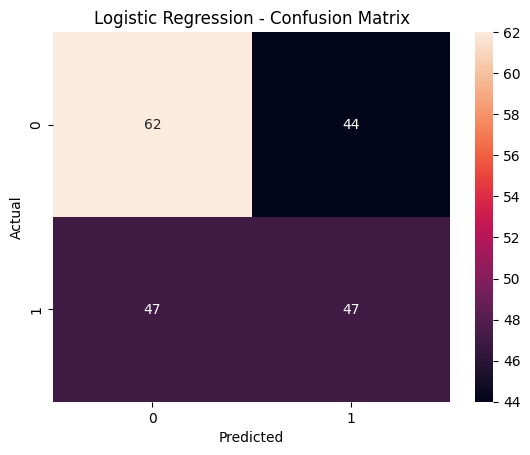

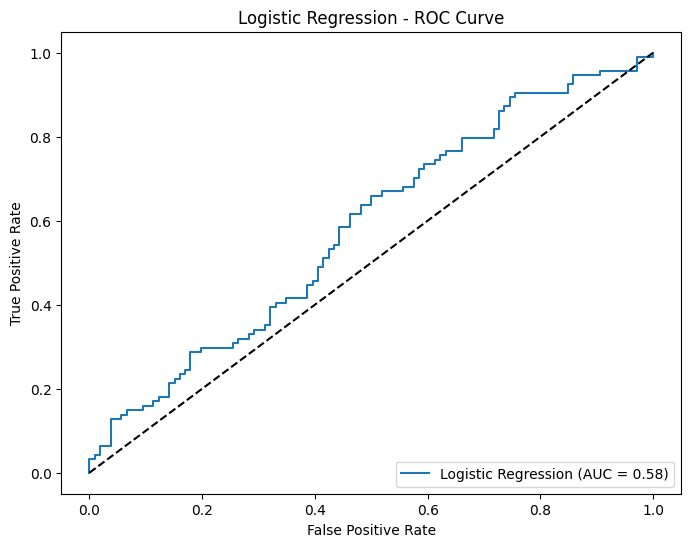

Processing model: Random Forest


c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\harim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py

Random Forest - Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       106
           1       0.63      0.68      0.66        94

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.67       200



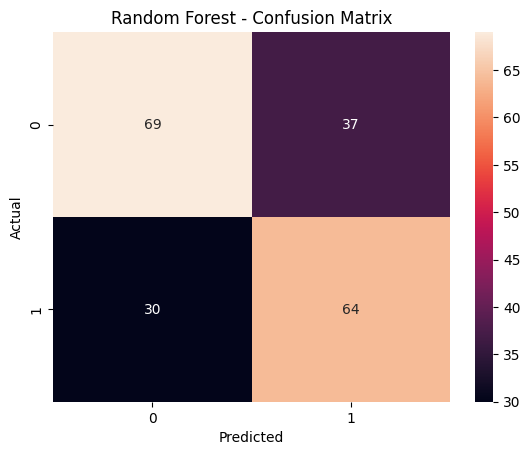

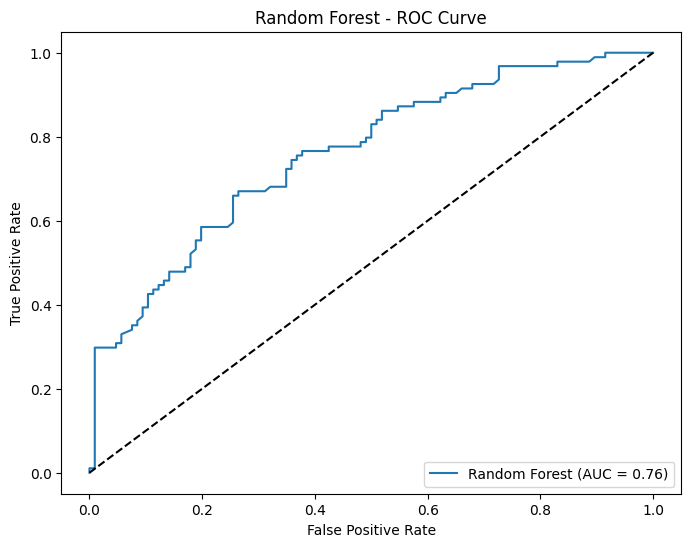

Processing model: Gradient Boosting
Gradient Boosting - Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       106
           1       0.59      0.67      0.63        94

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.62       200



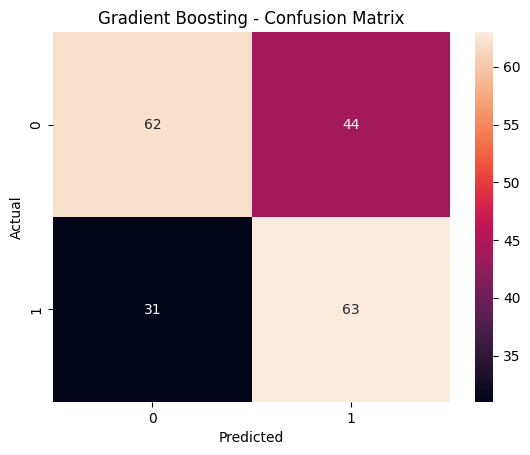

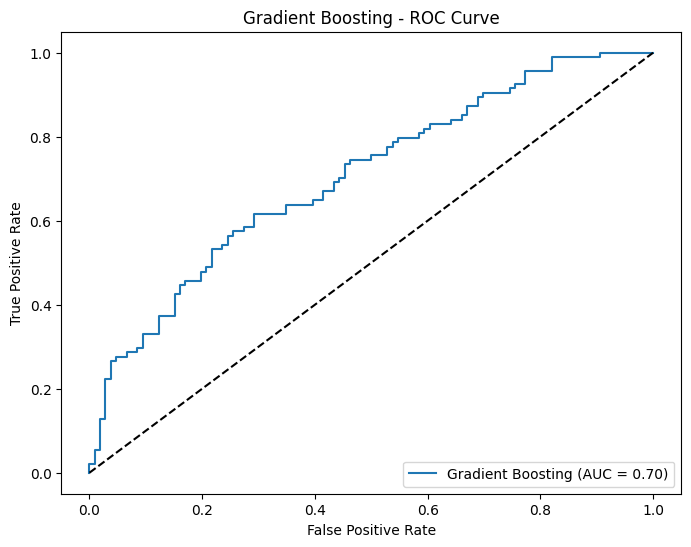

Processing model: XGBoost
XGBoost - Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       106
           1       0.65      0.64      0.65        94

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200



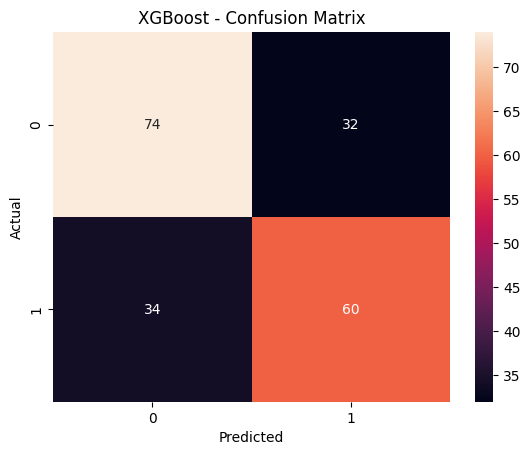

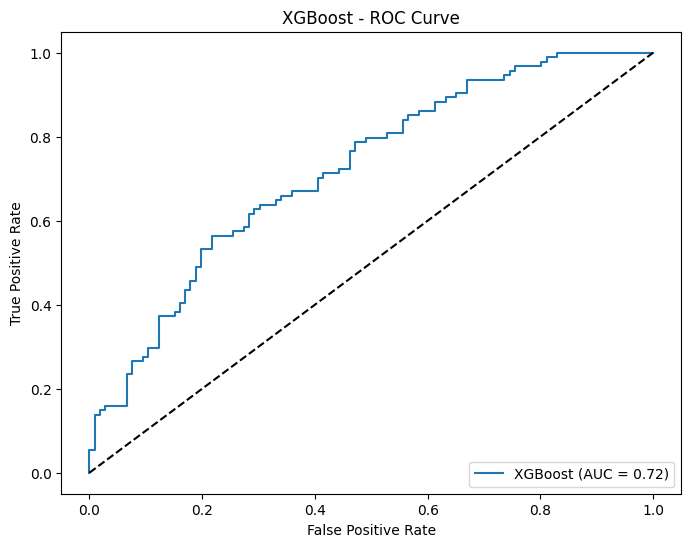

Processing model: SVM
SVM - Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       106
           1       0.60      0.66      0.63        94

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200



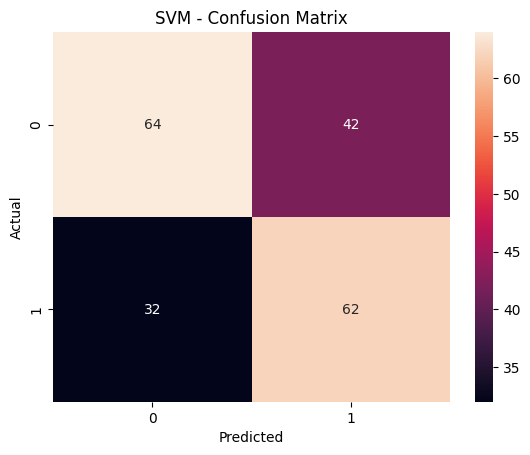

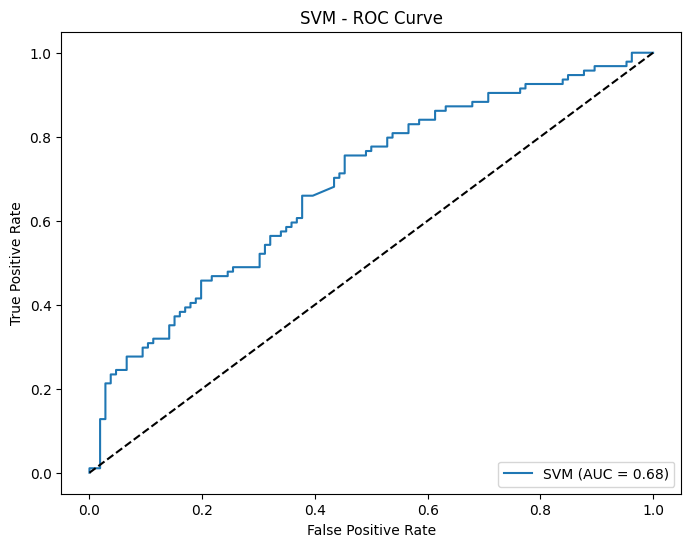

Voting Classifier - Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       106
           1       0.66      0.66      0.66        94

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



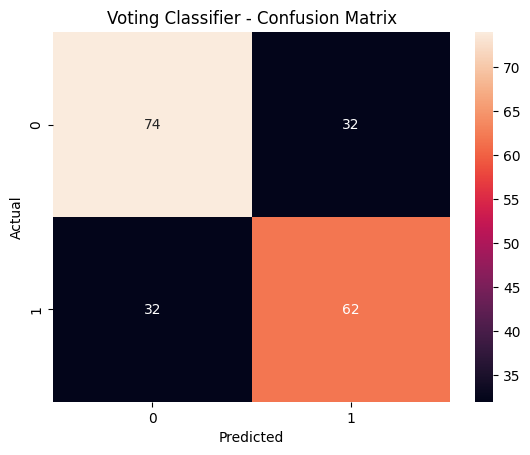

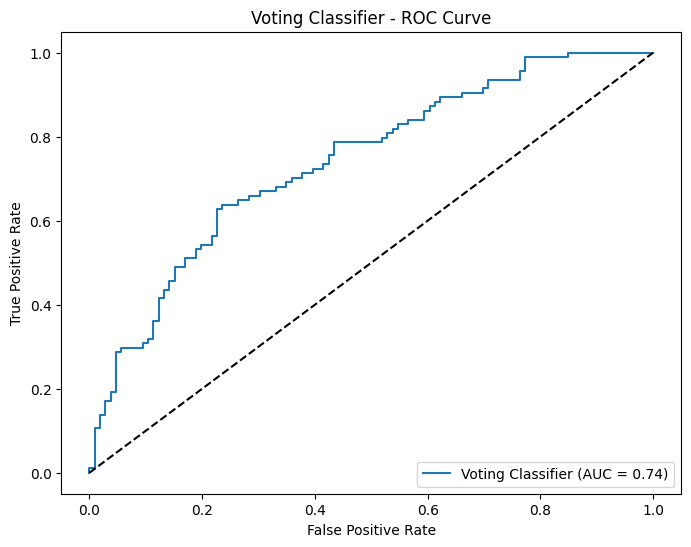


Summary of results:
Logistic Regression:
  Accuracy = 0.55
  Classification Report:
{'0': {'precision': 0.5688073394495413, 'recall': 0.5849056603773585, 'f1-score': 0.5767441860465117, 'support': 106.0}, '1': {'precision': 0.5164835164835165, 'recall': 0.5, 'f1-score': 0.5081081081081081, 'support': 94.0}, 'accuracy': 0.545, 'macro avg': {'precision': 0.5426454279665289, 'recall': 0.5424528301886793, 'f1-score': 0.54242614707731, 'support': 200.0}, 'weighted avg': {'precision': 0.5442151426555096, 'recall': 0.545, 'f1-score': 0.5444852294154621, 'support': 200.0}}

Random Forest:
  Accuracy = 0.67
  Classification Report:
{'0': {'precision': 0.696969696969697, 'recall': 0.6509433962264151, 'f1-score': 0.6731707317073171, 'support': 106.0}, '1': {'precision': 0.6336633663366337, 'recall': 0.6808510638297872, 'f1-score': 0.6564102564102564, 'support': 94.0}, 'accuracy': 0.665, 'macro avg': {'precision': 0.6653165316531653, 'recall': 0.6658972300281012, 'f1-score': 0.6647904940587868, '

In [290]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# Assuming `data` is the DataFrame containing the data

# Feature columns and target
feature_columns = ['vel_mean', 'vel_max', 'Average_Step_Length', 'Average_Step_Width']
target_column = 'patient_type'

# Encode categorical column if needed
label_encoder = LabelEncoder()
data_encoded = model_df.copy()
if 'patient' in model_df.columns:
    data_encoded['patient_encoded'] = label_encoder.fit_transform(model_df['patient'])

# Drop unnecessary columns for features
X = data_encoded[feature_columns]
y = data_encoded[target_column]

# Feature scaling using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define models and hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'max_features': ['auto', 'sqrt']}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    }
}

# Initialize dictionary to store results
results = {}

# GridSearchCV for hyperparameter tuning
for name, model_info in models.items():
    print(f"Processing model: {name}")

    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Model evaluation on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': report
    }

    # Print results
    print(f"{name} - Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Combine models using VotingClassifier
voting_clf = VotingClassifier(estimators=[(name, models[name]['model']) for name in models], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("Voting Classifier - Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Confusion matrix for Voting Classifier
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC curve for Voting Classifier
if hasattr(voting_clf, "predict_proba"):
    y_prob = voting_clf.predict_proba(X_test)[:, 1]
else:
    y_prob = voting_clf.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Voting Classifier (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier - ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Final model selection based on performance metrics
print("\nSummary of results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy = {metrics['Accuracy']:.2f}")
    print(f"  Classification Report:\n{metrics['Classification Report']}\n")

Processing model: Logistic Regression
Logistic Regression - Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        80
           1       0.47      0.14      0.22        49

    accuracy                           0.61       129
   macro avg       0.55      0.52      0.48       129
weighted avg       0.57      0.61      0.54       129



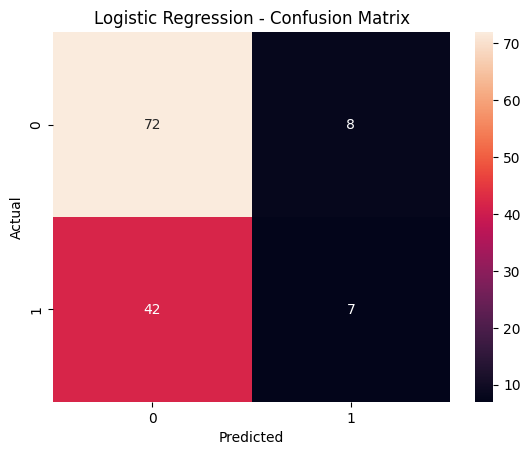

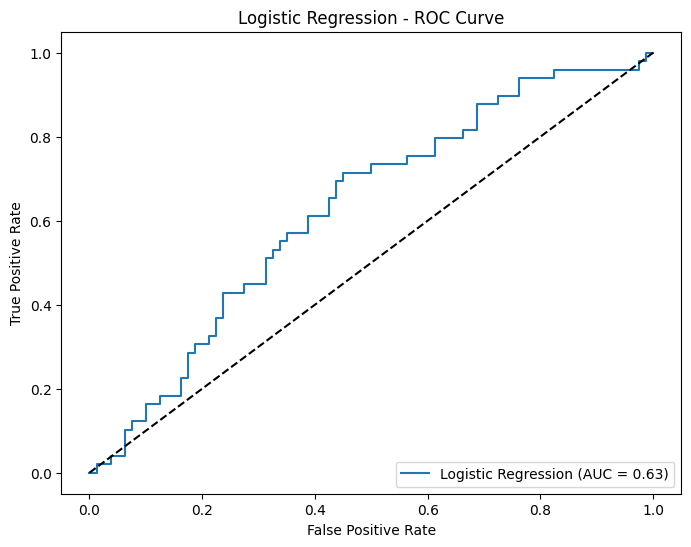

Processing model: Random Forest
Random Forest - Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.67      0.85      0.75        80
           1       0.57      0.33      0.42        49

    accuracy                           0.65       129
   macro avg       0.62      0.59      0.58       129
weighted avg       0.63      0.65      0.62       129



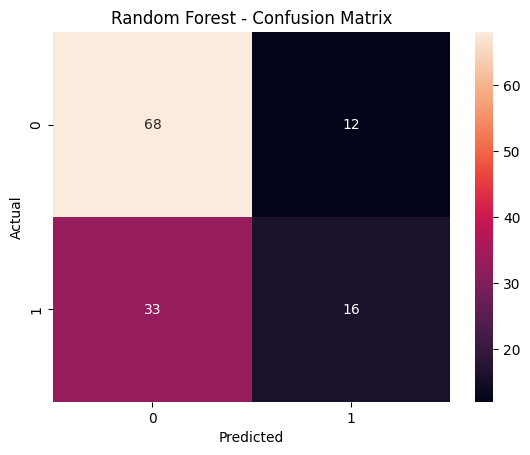

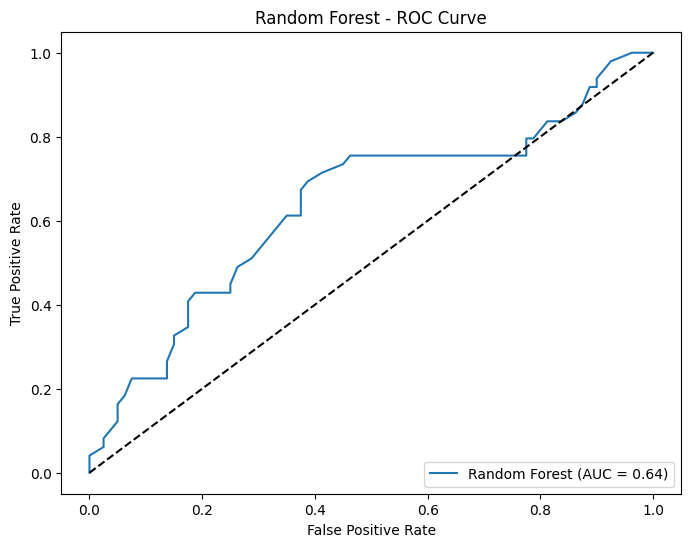

Processing model: Gradient Boosting
Gradient Boosting - Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        80
           1       0.61      0.41      0.49        49

    accuracy                           0.67       129
   macro avg       0.65      0.62      0.62       129
weighted avg       0.66      0.67      0.66       129



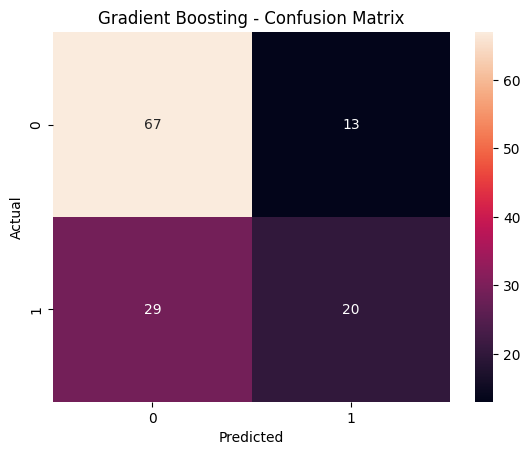

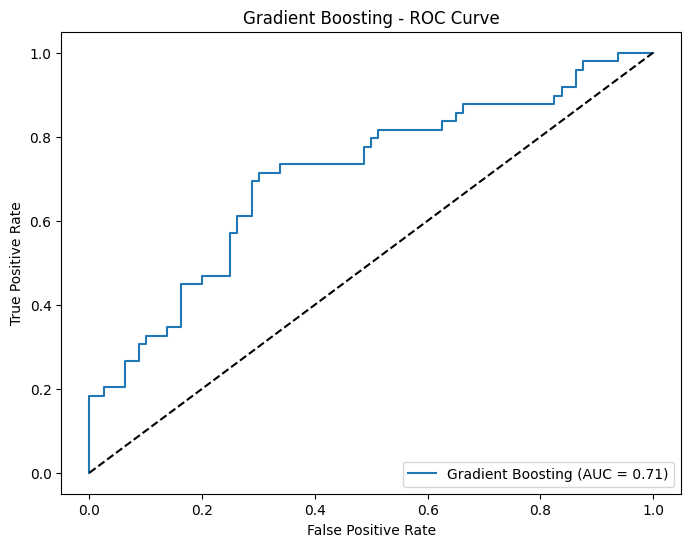

Processing model: XGBoost
XGBoost - Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        80
           1       0.60      0.53      0.57        49

    accuracy                           0.69       129
   macro avg       0.67      0.66      0.66       129
weighted avg       0.68      0.69      0.69       129



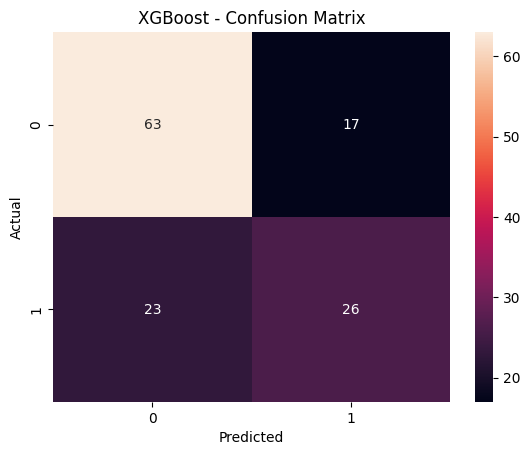

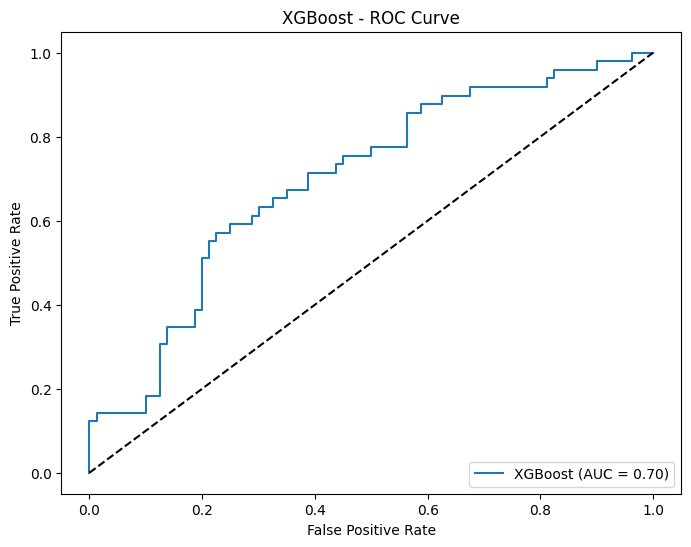

Processing model: SVM
SVM - Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.64      0.95      0.76        80
           1       0.60      0.12      0.20        49

    accuracy                           0.64       129
   macro avg       0.62      0.54      0.48       129
weighted avg       0.62      0.64      0.55       129



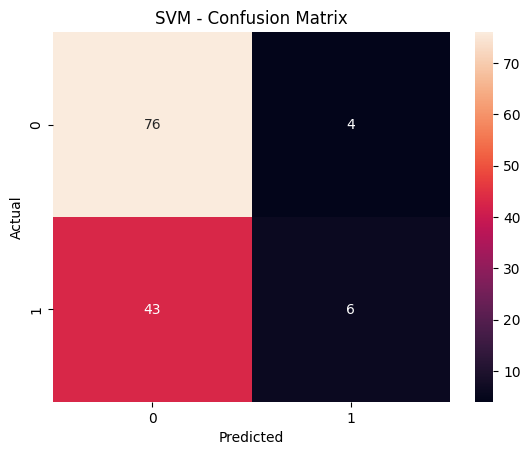

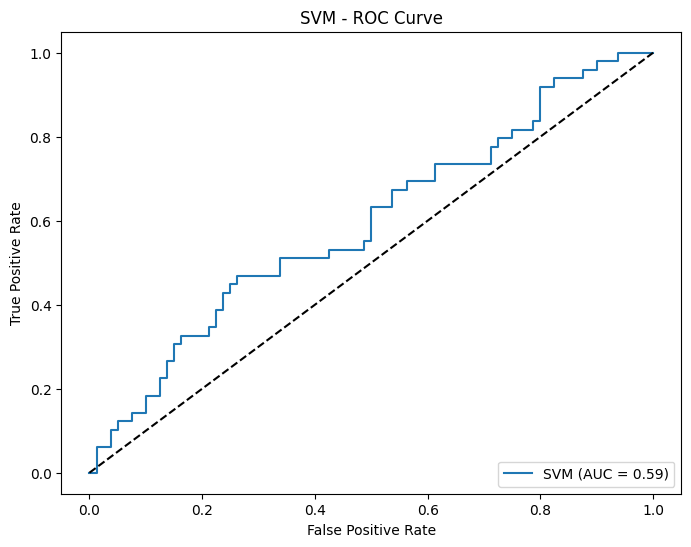

Voting Classifier - Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        80
           1       0.59      0.33      0.42        49

    accuracy                           0.66       129
   macro avg       0.63      0.59      0.59       129
weighted avg       0.64      0.66      0.63       129



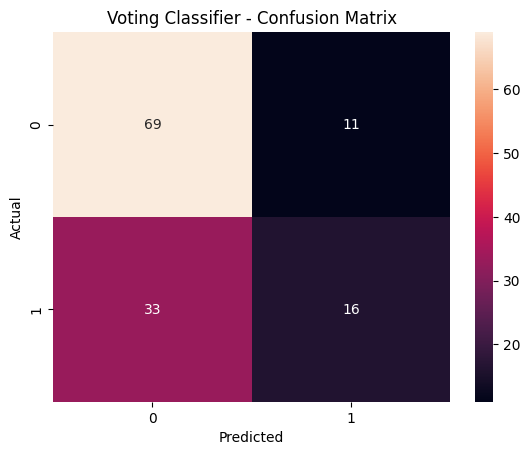

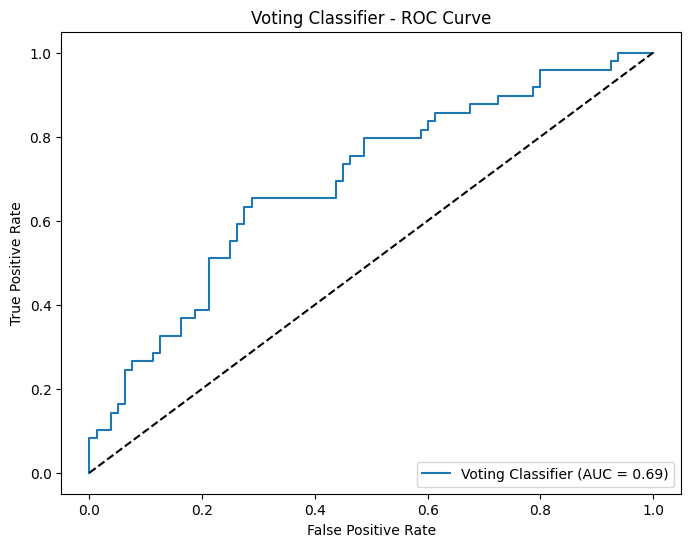

In [306]:
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

#Using age as a parameter for comparison

model_age = model_df.merge(qq, on = ('patient'))
model_age = model_age.iloc[:,[0,1,2,3,4,5,6,7,8,9,12,-1]]
model_age

feature_columns = ['vel_mean', 'vel_max', 'Average_Step_Length', 'Average_Step_Width', 'age']
target_column = 'patient_type'

# Add age-based binary features
model_age['age_50_plus'] = (model_age['age'] > 50).astype(int)

# Drop unnecessary columns for features
X = model_age[['vel_mean', 'vel_max', 'Average_Step_Length', 'Average_Step_Width', 'age', 'age_50_plus']]
y = model_age[target_column]

# Create interaction features between age and other features
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X[['vel_mean', 'vel_max', 'Average_Step_Length', 'Average_Step_Width', 'age']])
X_interactions_df = pd.DataFrame(X_interactions, columns=poly.get_feature_names_out())
X = pd.concat([X, X_interactions_df], axis=1)

# Feature scaling using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Evaluate models with Age and interaction features included
for name, model in models.items():
    print(f"Processing model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Combine models using Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logreg', LogisticRegression()),
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier - Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC curve
if hasattr(voting_clf, "predict_proba"):
    y_prob = voting_clf.predict_proba(X_test)[:, 1]
else:
    y_prob = voting_clf.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Voting Classifier (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier - ROC Curve')
plt.legend(loc="lower right")
plt.show()